In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM

data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(data)
df = df[df['Use'] == 1] # 13,299

n_lum_bins = 30 # number of luminosity bins
mag_lim = 27 # apparent magnitude limit (same as AB magnitude limit)
redshift_bins = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)] # redshift bins
bins = np.arange(-25, -10, 0.5) # luminosity bins
survey_area = 0.03556 # survey area in square degrees
min_count = 10 # minimum number of galaxies in a bin

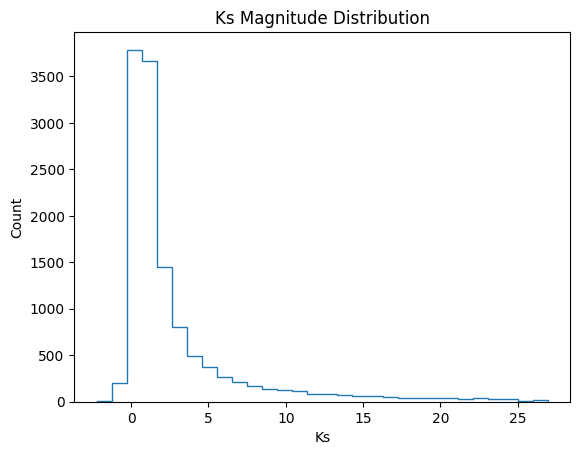

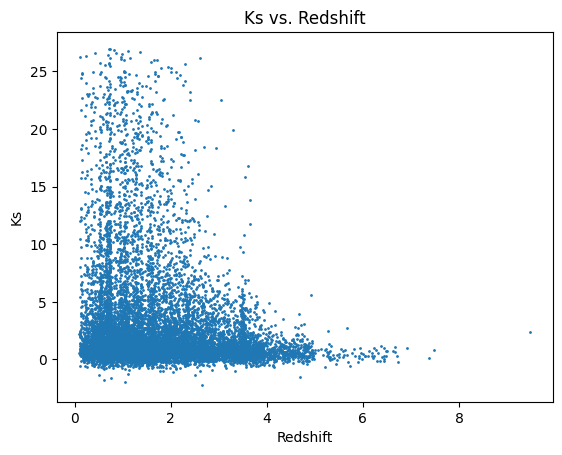

In [281]:
z = df['zpk'] # redshift
mag_app = df['FKs'] # apparent Ks magnitude

plt.hist(mag_app[df['FKs'] <= mag_lim], bins=n_lum_bins, histtype='step')
plt.title('Ks Magnitude Distribution')
plt.xlabel('Ks')
plt.ylabel('Count')
plt.show()

plt.scatter(z[df['FKs'] <= mag_lim], mag_app[df['FKs'] <= mag_lim], s=1)
plt.title('Ks vs. Redshift')
plt.xlabel('Redshift')
plt.ylabel('Ks')
plt.show()

C:\Users\n10480129\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


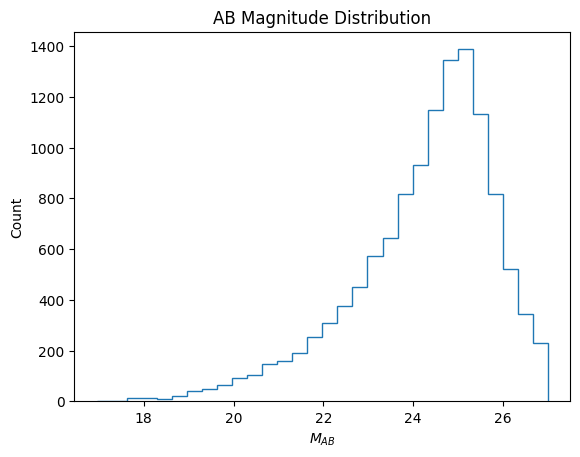

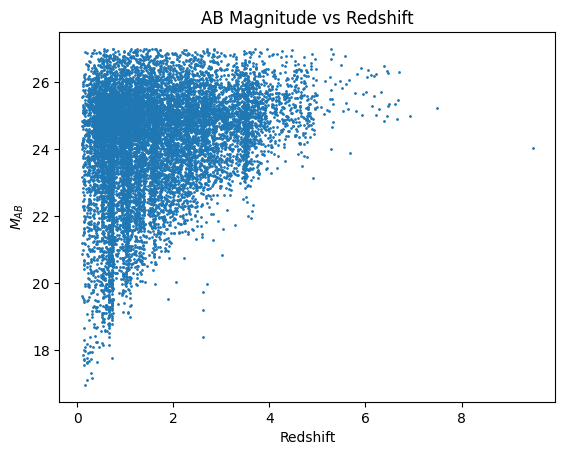

In [282]:
mag_ab = 25 - 2.5*np.log10(mag_app) # apparent magnitude -> AB magnitude

plt.title('AB Magnitude Distribution')
plt.hist(mag_ab[mag_ab <= mag_lim], bins=n_lum_bins, histtype='step')
plt.xlabel('$M_{AB}$')
plt.ylabel('Count')
plt.show()

plt.scatter(z[mag_ab <= mag_lim], mag_ab[mag_ab <= mag_lim], s=1)
plt.title('AB Magnitude vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('$M_{AB}$')
plt.show()

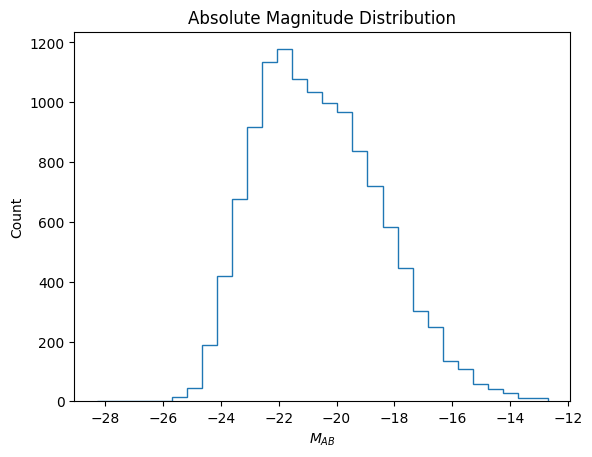

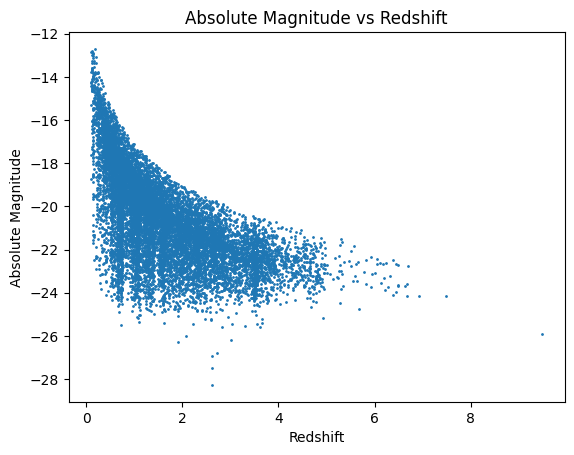

In [284]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
dists = cosmo.luminosity_distance(z) # Mpc
dists *= 10 ** 6 # Mpc -> pc
Mag_abs = mag_ab - 5 * np.log10(dists / 10) # AB magnitude -> absolute magnitude

plt.title('Absolute Magnitude Distribution')
plt.hist(Mag_abs[mag_ab <= mag_lim], bins=n_lum_bins, histtype='step')
plt.xlabel('$M_{AB}$')
plt.ylabel('Count')
plt.show()

plt.scatter(z[mag_ab <= mag_lim], Mag_abs[mag_ab <= mag_lim], s=1)
plt.title('Absolute Magnitude vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('Absolute Magnitude')
plt.show()

-6.350768707170141
-16.955697423822805


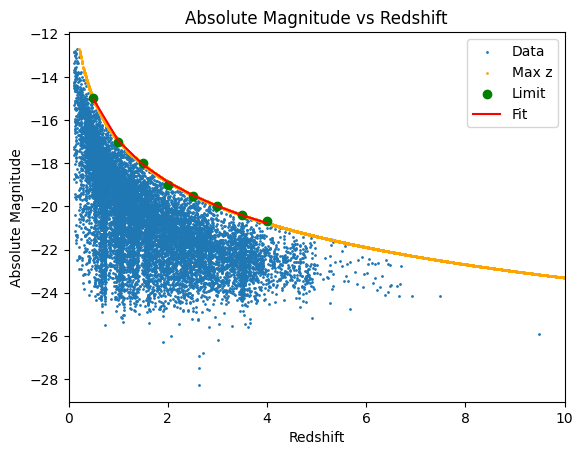

In [285]:
z = z[mag_ab <= mag_lim]
Mag_abs = Mag_abs[mag_ab <= mag_lim]

x_points = np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])
y_points = np.array([-15, -17, -18, -19, -19.5, -20, -20.4, -20.7])

def log_fit(x, a, b):
    return a * np.log10(x) + b

params, covars = curve_fit(log_fit, x_points, y_points)

for p in params:
    print(p)
    
max_z = 10 ** ((Mag_abs + 16.95) / (-6.35))

plt.scatter(z, Mag_abs, s=1, label='Data')
plt.scatter(max_z, Mag_abs, s=1, color='orange', label='Max z')
plt.scatter(x_points, y_points, color='green', label='Limit')
plt.plot(x_points, log_fit(x_points, *params), color='red', label='Fit')
plt.title('Absolute Magnitude vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('Absolute Magnitude')
plt.xlim(0, 10)
plt.legend()
plt.show()

In [286]:
all_data = []

for z_min, z_max in redshift_bins:
    
    # Bin the data by redshift
    z_mask = (z >= z_min) & (z < z_max)
    Mag_abs_bin = Mag_abs[z_mask]
    
    # Bin the data by luminosity
    counts, lum_bin_edges = np.histogram(Mag_abs_bin, bins=bins)
    lum_bin_centers = lum_bin_edges[0:-1] + (np.diff(lum_bin_edges)[0] / 2)
    
    # Calculate the minimum and maximum distance of the redshift bin
    dmin = cosmo.comoving_distance(z_min).value
    dmax = cosmo.comoving_distance(z_max).value
    
    # Calculate the maximum distance of each luminosity bin
    dmaxs = (10 * 10 ** ((mag_lim - lum_bin_centers) / 5)) # pc
    dmaxs = dmaxs / 10 ** 6 # pc -> Mpc
    
    # # Calculate the maximum distance of each luminosity bin
    # max_z = 10 ** ((lum_bin_centers + 16.95) / (-6.35))
    # dmaxs = cosmo.comoving_distance(max_z).value
    
    # If the maximum distance is greater than the maximum redshift bin distance, set it to the maximum redshift bin distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each luminosity bin
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    all_data.append([counts, vol, lum_bin_centers, Mag_abs_bin])

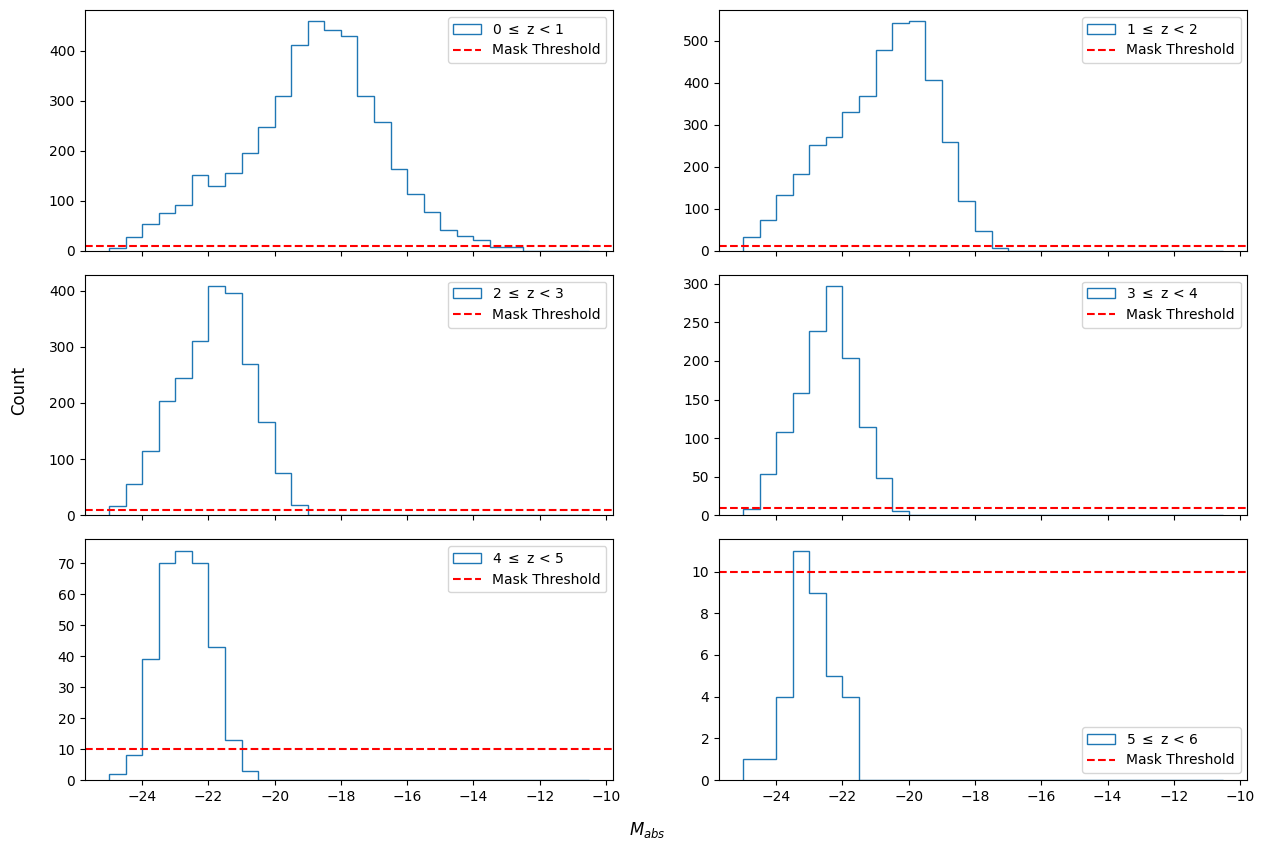

In [287]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True)
for ax, d, (z_start, z_end) in zip(axes.flatten(), all_data, redshift_bins):
    _, _, _, binned_data = d
    ax.hist(binned_data, bins=bins, histtype='step', label=f'{z_start} $\leq$ z < {z_end}')
    ax.axhline(min_count, color='red', linestyle='--', label='Mask Threshold')
    ax.legend()

fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('Count', x=0.075)
plt.subplots_adjust(hspace=0.1)
plt.show()

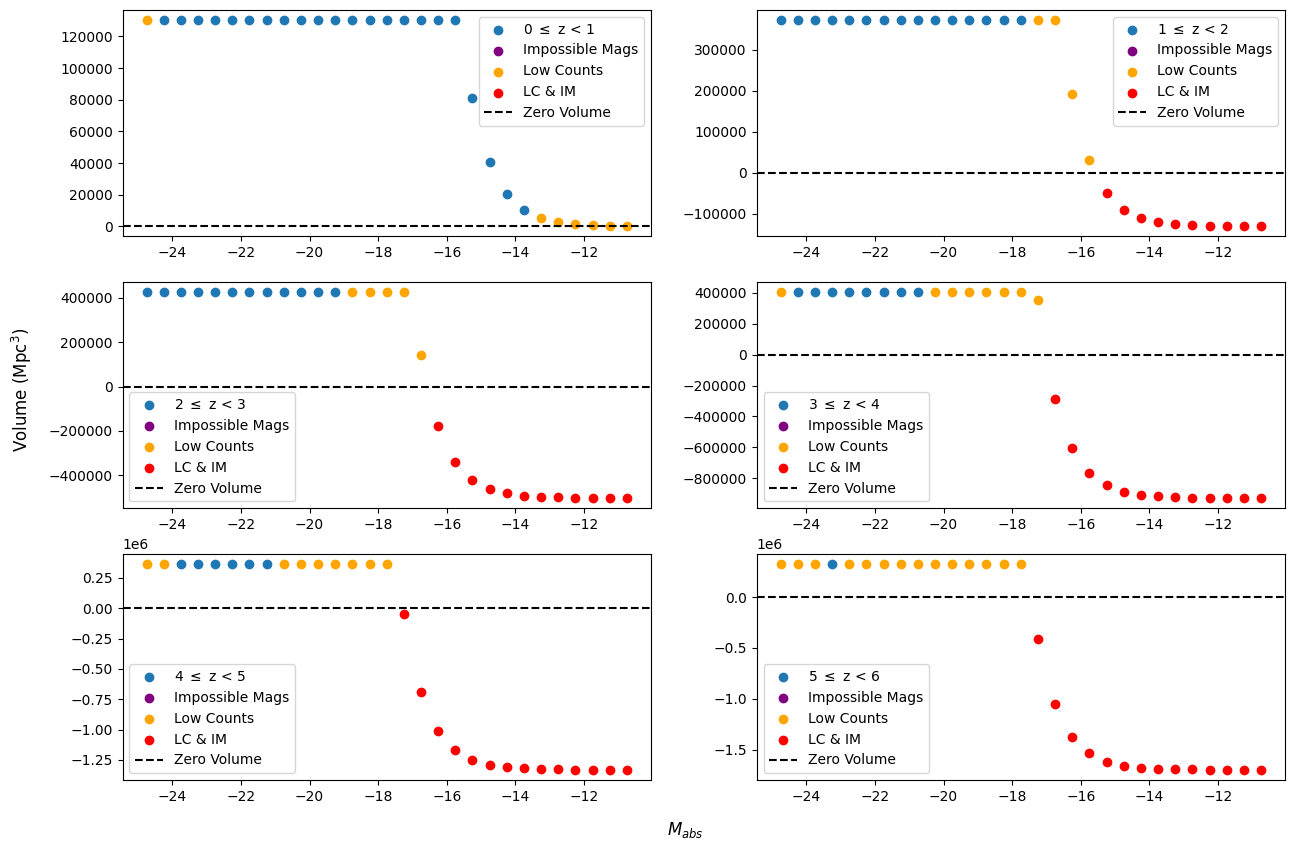

In [288]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
for ax, d, (z_start, z_end) in zip(axes.flatten(), all_data, redshift_bins):
    counts, volume, lum_bin_centers, _ = d
    
    good_all_mask = (counts > min_count) & (volume > 0)
    bad_volume_mask = (volume <= 0) & (counts > min_count)
    bad_counts_mask = (counts <= min_count) & (volume > 0)
    bad_all_mask = (counts <= min_count) & (volume <= 0)
    
    ax.scatter(lum_bin_centers[good_all_mask], volume[good_all_mask], label=f'{z_start} $\leq$ z < {z_end}')
    ax.scatter(lum_bin_centers[bad_volume_mask], volume[bad_volume_mask], color='purple', label='Impossible Mags')
    ax.scatter(lum_bin_centers[bad_counts_mask], volume[bad_counts_mask], color='orange', label='Low Counts')
    ax.scatter(lum_bin_centers[bad_all_mask], volume[bad_all_mask], color='red', label='LC & IM')
    ax.axhline(0, color='black', linestyle='--', label='Zero Volume')
    ax.legend()
    
fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('Volume (Mpc$^3$)', x=0.05)
plt.show()

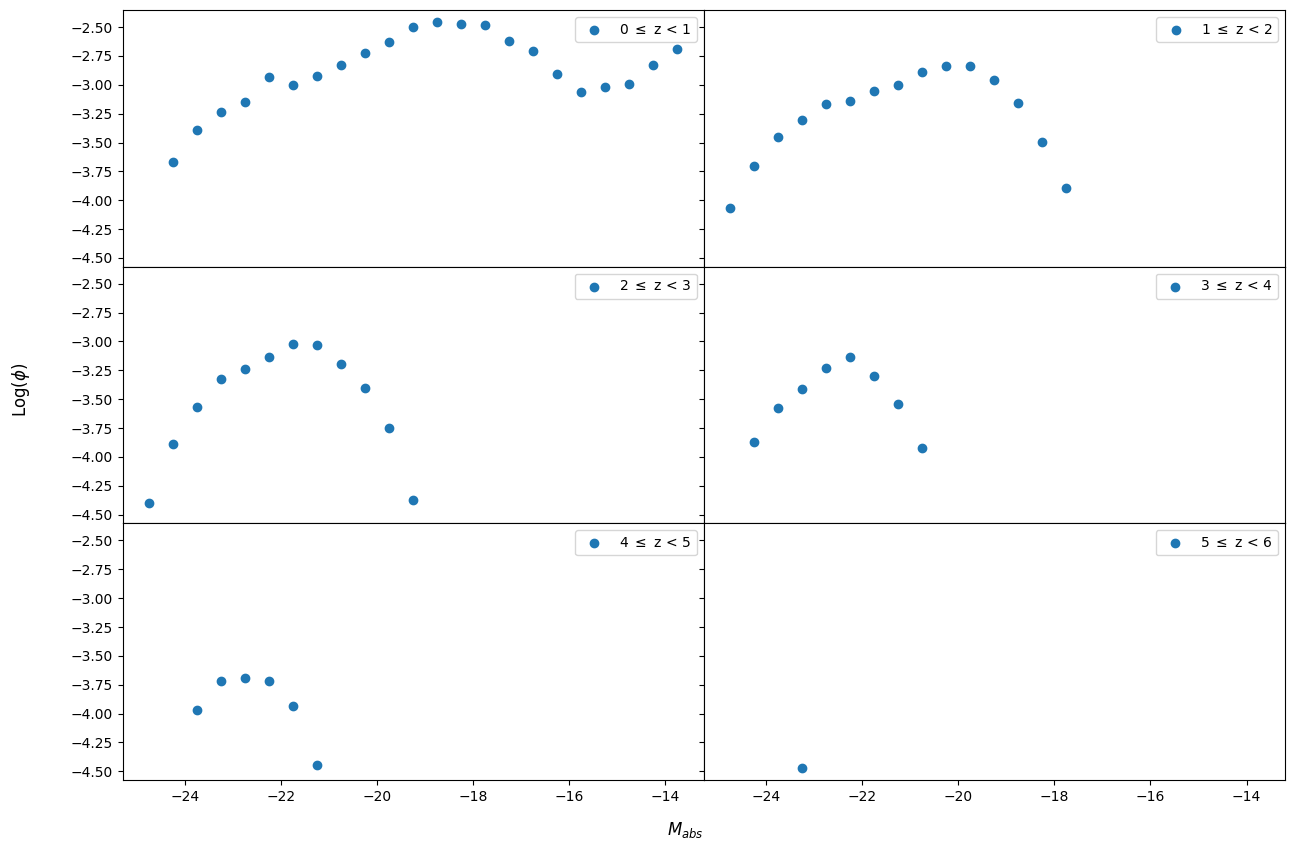

In [289]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for ax, d, (z_start, z_end) in zip(axes.flatten(), all_data, redshift_bins):
    counts, volume, lum_bin_centers, _ = d
    
    mask = (counts > min_count) & (volume > 0)
    
    counts = counts[mask]
    volume = volume[mask]
    lum_bin_centers = lum_bin_centers[mask]
    
    ax.scatter(lum_bin_centers, np.log10(counts / volume), label=f'{z_start} $\leq$ z < {z_end}')
    ax.legend()

fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()